# Исследование продаж видеоигр

В этом проекте мы будем работать с историческими данными о продажах игр, оценки пользователей и экспертов, жанры и платформы. Основная задача - выявить определяющие успешность игры закономерности, что позволит заказчику сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Цели исследования:**
 1. Изучить общую информацию о продажах видеоигр.
 2. Изучить зависимость продаж видеоигр от платформ, построить показательные графики.
 3. Определить несколько наиболее прибыльные платформы.
 4. Определить как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.
 5. Проверить гипотезы о средних рейтингах определенных платформ и жанров игр.

**Ход исследования:**
 1. Первоначальный обзор данных, получение общего представления о датафрейме и его столбцах.
 2. Предобработка данных.
 3. Исследовательский анализ данных.
 4. Проверка гипотез.
 5. Выводы.


# Обзор данных

Для начала импортируем все необходимые библиотеки.

In [1]:
import pandas as pd
from scipy import stats as st
from math import factorial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Прочитаем файл с датафреймом и сохраним его в переменной.

In [2]:
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('games.csv')

Изучим общую информацию о датафрейме.

In [3]:
df.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
10247,Classic Road,SNES,1993.0,Sports,0.00,0.00,0.11,0.00,NaN,NaN,NaN
15348,Whiteout,PS2,2002.0,Racing,0.01,0.01,0.00,0.00,50.0,tbd,T
3389,NFL Blitz 2001,PS,2000.0,Sports,0.33,0.22,0.00,0.04,70.0,tbd,E
9344,Pro Yaky? Spirits 6,PS2,2009.0,Sports,0.00,0.00,0.13,0.00,NaN,NaN,NaN
11560,Pac-Man and the Ghostly Adventures 2,3DS,2014.0,Adventure,0.03,0.04,0.00,0.01,60.0,tbd,E10+


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Согласно документации, в датафрейме 11 колонок:

1. **Name** — название игры
2. **Platform** — платформа
3. **Year_of_Release** — год выпуска
4. **Genre** — жанр игры
5. **NA_sales** — продажи в Северной Америке (миллионы проданных копий)
6. **EU_sales** — продажи в Европе (миллионы проданных копий)
7. **JP_sales** — продажи в Японии (миллионы проданных копий)
8. **Other_sales** — продажи в других странах (миллионы проданных копий)
9. **Critic_Score** — оценка критиков (максимум 100)
10. **User_Score** — оценка пользователей (максимум 10)
11. **Rating** — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).

Построим гистограммы для каждого столбца.

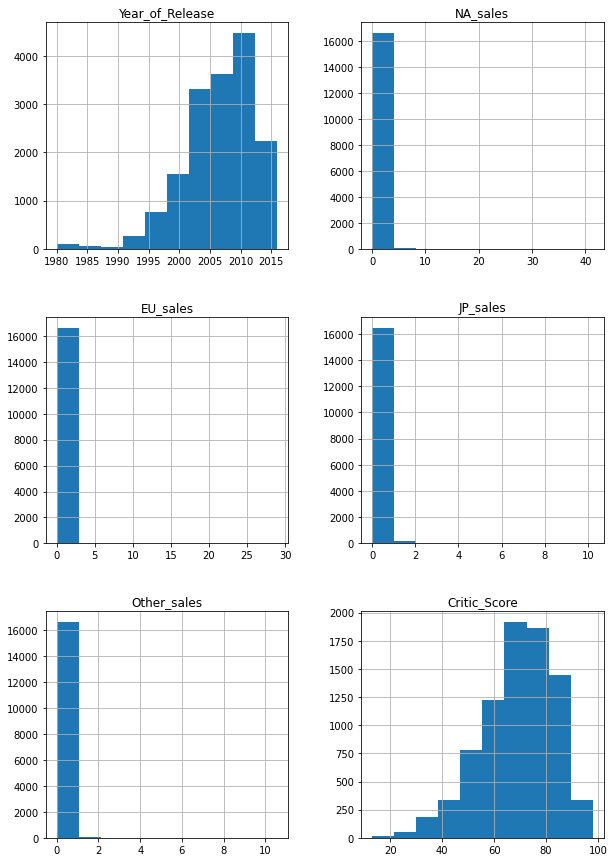

In [6]:
df.hist(figsize=(10, 15));

Проверим наличие пропусков и явных дубликатов.

In [7]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [8]:
df.duplicated().sum()

0

**Вывод:** Итак, мы сделали первоначальный осмотр датафрейма. Сразу можно отметить некорректный тип данных в некоторых столбцах и наличие пропусков. Также следует привести названия некоторых столбцов к нижнему регистру и добавить в датафрейм столбец с суммарной продажей во всех регионах.

# Предобработка данных

Для начала заменим названия некоторых столбцов (приведем к нижнему регистру).

In [9]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Теперь поработаем с типом данных в столбцах. Поменяем тип в столбце с годом выпуска на целочисленный, так как год не может быть дробным числом. Но сначала посчитаем количество пропусков в этом столбце.

In [10]:
df['year_of_release'].isna().sum()
df['year_of_release'].isna().sum()/df.shape[0]*100

1.609332934489979

269 - это примерно 1.6% процентов, значит строки с пропусками в годах можно удалить.

In [11]:
df = df.dropna(subset=['year_of_release'])

In [12]:
# Теперь поменяем тип
df['year_of_release'] = df['year_of_release'].astype('int') 
df['year_of_release'].unique()

array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000, 1995, 1991,
       1981, 1987, 1980, 1983])

Теперь разберемся с пропусками в остальных столбцах. 

In [13]:
df.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         6607
rating             6678
dtype: int64

По 2 пропуска в столбцах с названием игры и жанром можно смело удалять.

In [14]:
df = df.dropna(subset=['name'])
df = df.dropna(subset=['genre'])

Пропуски в столбцах с оценкой критиков и пользователей, а также рейтинга возрастной категории лучше оставить, так как, скорее всего, в 1980 году (а это самая старая в датафрейме игра) еще не было никаких рейтингов и оценок игр от критиков.

Пропусков в столбце с оценками критиков больше, чем с оценками пользователей. Такое могло произойти из-за того, что зачастую критики оценивают наиболее популярные игры, а вот игры с небольшим комьюнити оценивают только игроки.

Проверим наши догадки.

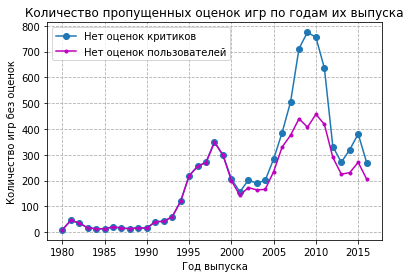

In [15]:
critics_score_nan_year = (df.loc[df['critic_score'].isna()==True]\
                      .pivot_table(index='year_of_release', values='name', aggfunc='count')\
                      .reset_index())
user_score_nan_year = (df.loc[df['user_score'].isna()==True]\
                      .pivot_table(index='year_of_release', values='name', aggfunc='count')\
                      .reset_index()
                     )


fig, ax = plt.subplots()
ax.set(title='Количество пропущенных оценок игр по годам их выпуска',
       xlabel='Год выпуска', ylabel='Количество игр без оценок')
ax.plot(critics_score_nan_year['year_of_release'], critics_score_nan_year['name'], 'o-', label='Нет оценок критиков')
ax.plot(user_score_nan_year['year_of_release'], user_score_nan_year['name'], '.-m', label='Нет оценок пользователей')
ax.grid(linestyle='--')
ax.legend(frameon=True)
plt.show()

Действительно, примерно до 1995 года отзывов было намного меньше, причем как от критиков, так и от игроков. Но постепенно стали появляться сайты с отзывами, игровое комьюинити расширялось и желающих поделиться своим мнением об игре стало больше.

Теперь разберемся с аббревиатурой 'tbd' ("to be determined" - "Будет определено") в столбце с оценкой пользователей. Заменим это значение пропусками и поменяем тип на float.

In [16]:
df.user_score.replace('tbd', np.nan, inplace=True)
df['user_score'] = df['user_score'].astype('float')

In [17]:
df['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

Cистема ESRB (Совет по рейтингу развлекательного программного обеспечения) делит все игры на 7 категорий:

**EC** - Для детей младшего возраста. Подходит для детей от 3 лет, неприемлемое содержание отсутствует.

**E** - Подходит для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Не должна использоваться ненормативная лексика. Первоначально K-A ("Kids to Adults")

**E 10+** - Подходит для лиц старше 10 лет. Игра может содержать умеренные формы насилия, а некоторые сцены могут пугать детей.

**T** - Подходит для лиц старше 13 лет. Игра может содержать более реалистичные и натуралистические сцены насилия. Примеры: Fortnite, Sims 4.

**M** - Подходит для лиц старше 17 лет. Этот рейтинг используется, когда насилие становится реалистичным и похожим на реальную жизнь. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или запрещенных наркотиков.

**AO** - Подходит для взрослых старше 18 лет. Классификация «для взрослых» используется, когда в игре присутствует крайний уровень насилия и немотивированного убийства. Также может присутствовать романтизация наркотиков, азартных игр и сексуальной активности.|

**RP** - Категория ещё не присвоена. Играм с категорией RP еще не присвоен окончательный рейтинг ESRB.

Рейтинг ESRB - это метод оценки игр для США и Канады. Пропуски в этом столбце могут означать следующее:
<ul>
  <li>Игра продается в США или Канаде, но рейтинг для нее пока не установлен.</li>
  <li>Игра продается в другом регионе, где рейтинг ESRB не используется. </li>
</ul>


Тогда заменим пропуски на значение 'no_ESRB', что означает отсутствие рейтинга у игры на данный момент.

In [18]:
df.loc[df['rating'] == 'K-A', 'rating'] = 'E'
df.loc[df['rating'] == 'EC', 'rating'] = 'E'
df['rating'] = df['rating'].fillna('no_ESRB')

Теперь проверим наличие явных дубликатов.

In [19]:
df.duplicated().sum()

0

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [20]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [21]:
df.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,no_ESRB,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,no_ESRB,31.38


In [22]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = df.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

# Анализ данных

## Сколько игр выпускалось в разные годы?

Перейдем к анализу данных. Узнаем сколько игр выпускалось в разные годы на разные платформы.

In [23]:
games_per_year_pivot = df.pivot_table(index = 'year_of_release',  
                                columns='platform', 
                                values='name',
                                aggfunc='count',
                                fill_value=0, margins=True).reset_index()

games_per_year_pivot.sample(5)

platform,year_of_release,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,...,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne,All
18,1998,0,0,0,7,0,8,0,0,0,...,0,2,0,0,0,0,0,0,0,379
22,2002,0,0,0,1,0,0,198,152,0,...,0,0,0,0,0,0,0,158,0,829
20,2000,0,0,0,20,0,17,1,0,0,...,0,0,0,2,0,0,0,1,0,350
6,1986,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
8,1988,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,15


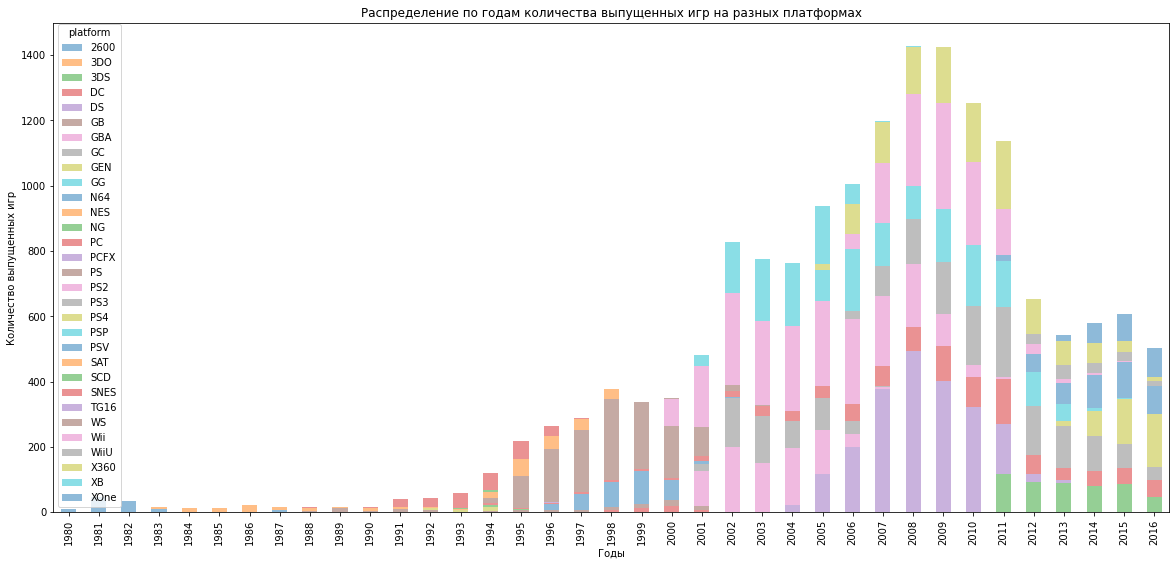

In [24]:
fig, ax = plt.subplots()

games_per_year = df.pivot_table(index = 'year_of_release',  
                                columns='platform', 
                                values='name',
                                aggfunc='count').plot(kind='bar',stacked=True, ax=ax,figsize=(20,9), alpha=0.5)
ax.set_xlabel('Годы')
ax.set_ylabel('Количество выпущенных игр')
ax.set_title('Распределение по годам количества выпущенных игр на разных платформах')
plt.show()

In [25]:
games_per_year_pivot[['year_of_release', 'All']].sort_values(by='All', ascending=False)

platform,year_of_release,All
37,All,16444
28,2008,1427
29,2009,1426
30,2010,1255
27,2007,1197
31,2011,1136
26,2006,1006
25,2005,939
22,2002,829
23,2003,775


В целом, количество игр за все время сильно увеличилось, однако с течением времени появлялись новые платформы, поэтому во всем датафрейме их состав постоянно менялся. Наиболее количество игр вышло в 2005-2011 годах, а наименьшее в 1980 году. Данные с 1980 по примерно 1995 г. не такие показательные, так как за год выпускалось от силы 20 игр, что очень мало по отношению к другим годам. Несмотря на устойчивый рост, после 2011 года заметна тенденция к снижению количества выпускаемых игр, что может быть связано с выходом на рынок новых платформ.

## Как менялись продажи по платформам?

Теперь выберем несколько платформ с наибольшими суммарными продажами и построим распределение по годам.

In [26]:
top_10_platforms = df.groupby('platform')\
.sum()['total_sales']\
.reset_index()\
.sort_values(by='total_sales', ascending=False)\
.head(10)
top_10_platforms

,platform,total_sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.34
26,Wii,891.18
4,DS,802.78
15,PS,727.58
18,PS4,314.14
6,GBA,312.88
19,PSP,289.53
2,3DS,257.81


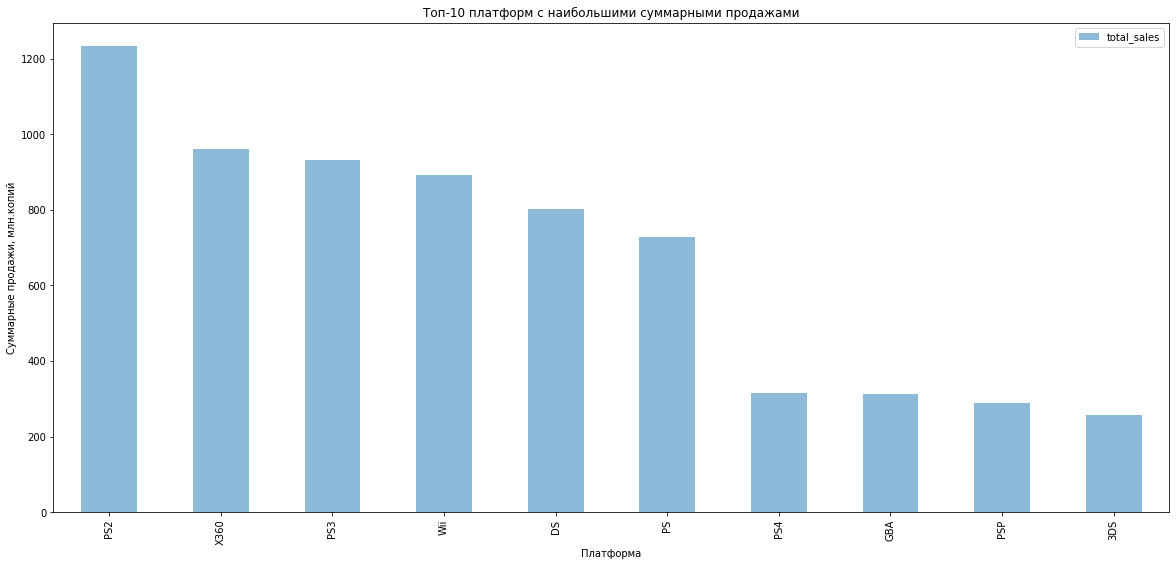

In [27]:
fig, ax = plt.subplots()
top_10_platforms = df.pivot_table(index = 'platform', values='total_sales',
                                aggfunc='sum').sort_values(by='total_sales', ascending=False)\
.head(10).plot(kind='bar',stacked=True, ax=ax,figsize=(20,9), alpha=0.5)

ax.set_xlabel('Платформа')
ax.set_ylabel('Суммарные продажи, млн.копий')
ax.set_title('Топ-10 платформ с наибольшими суммарными продажами')
plt.show()

По графику видно, что в датфрейме продажи игр для первых 6 платформ значетельно превосходят последующие, однако для полноты выборки возмем еще и PS4. Теперь, выбрав наиболее популярные платформы, построим для них распределение по годам, чтобы узнать за какой характерный срок появляются новые и исчезают старые платформы.

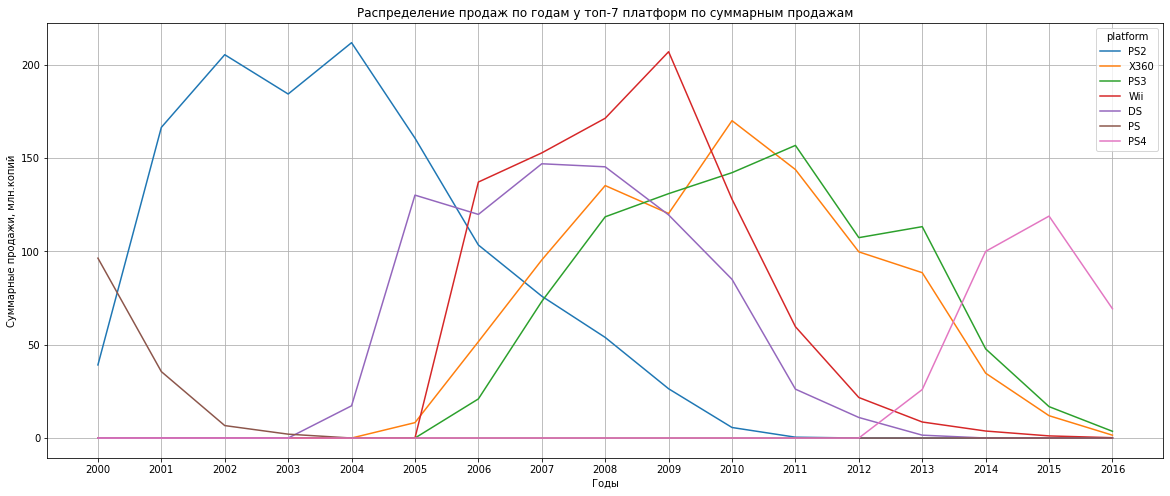

In [28]:
data_top_sales = df.query('2017 > year_of_release >= 2000').pivot_table(
    index = 'year_of_release', 
    columns = 'platform',
    values = 'total_sales', 
    aggfunc = 'sum'
    ).fillna(0)

data_top_sales = data_top_sales[['PS2', 'X360','PS3','Wii', 'DS', 'PS', 'PS4']]
ax = data_top_sales.plot(xticks=data_top_sales.index,figsize=(20,8), grid=True)
ylab = ax.set_ylabel('Суммарные продажи, млн.копий')
xlab = ax.set_xlabel('Годы')
plt.title('Распределение продаж по годам у топ-7 платформ по суммарным продажам')
plt.show()     

Суммарные продажи разных платформ довольно значительно отличаются, некоторые платформы достигают 200 млн. за свой срок, а для некоторых 50-70 млн. копий является пиковым значением. В среднем период "жизни" платформы составляет примерно 5 лет. За это время продажи игр достигают примерно 25% процентов от максимального уровня. Затем примерно через 5 лет это значение повторяется, но уже на стадии спада продаж, после того, как продажи достигли своего пика.  

Самой продаваемой платформой долгое время была PS2. В свой период у неё практичеки не было конкурентоспособных аналогов, она в течение долгого времени занимала топовые позиции. Второе и третье места делят между собой Xbox360, Playstation3, DS и Wii: игры на этих платформах были популярны в одни и те же годы, и предпочтения потребителей игр разделились между ними. Продажи на PS4 с 2015 года показывают спад, также как и платформы 3DS, PS3 и X360 (три последние уже практически исчезли с рынка). Можно предположить, что в скором времени значительную долю рынка займут новые платформы. Также вполне возможнен рост продаж PS4 по аналогии с PS3, когда за период 2012-2013 гг., несмотря на спад, продажи на эту платформу несколько увеличились за этот год.

Тем не менее, с целью составления прогноза по продажам на 2017 год наиболее целесообразно взять актуальный период в 2-3 года. Связано это с тем, что в такой динамичной индустрии как рынок компьютерных игр (много разных платформ появляется за относительно короткий период времени), промежуток в 5 лет - приблизительное время жизни одной платформы - это довольно долго. Скорее всего, чем больше актуальный период, тем больше ненужных платформ придется анализировать, а уже практически "мертвые" тренды вряд ли кого-то интересуют.

Таким образом, для построения прогноза по продажам на 2017 год возьмем данные за 2014-2016 года.

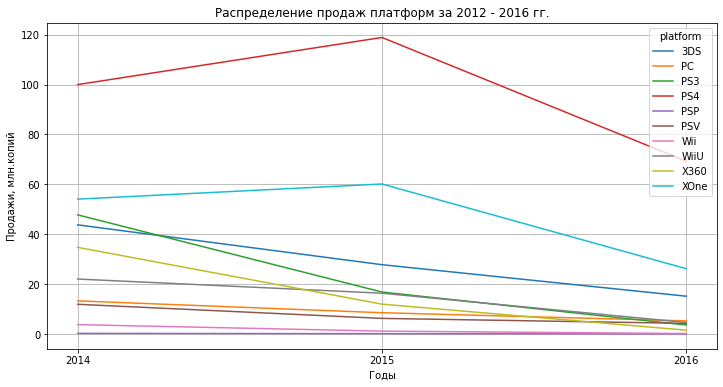

In [29]:
data_sales_2014_2016 = df.query('year_of_release >= 2014').pivot_table(
    index = 'year_of_release', 
    columns = 'platform',
    values = 'total_sales', 
    aggfunc = 'sum'
    ).fillna(0)

ax = data_sales_2014_2016.plot(xticks=data_sales_2014_2016.index,figsize=(12,6), grid=True)
ylab = ax.set_ylabel('Продажи, млн.копий')
xlab = ax.set_xlabel('Годы')
plt.title('Распределение продаж платформ за 2012 - 2016 гг.')
plt.show()     

Так, из данных на графике, можно выбрать несколько плафторм, которые могут принести потенциальную прибыль. Консоли PS4, вышедшие в 2013 году продолжают набирать популярность, что в целом, естественно, учитывая, что прошла только пололвина её жизненного цикла.

Затем идет Xone - прямой конкурент PS4. Топ-3 замыкает платформа 3DS. Следует отметить, что каждая из эти платформ показывает спад, что может быть связано с присутствием на рынке значительного числа менее популярных платформ, скорее всего, когда их жизненный цикл подойдет к концу, их пользователи перейдут на более популярные платформы.

In [30]:
df_2014_2016 = df.query('year_of_release >= 2014')

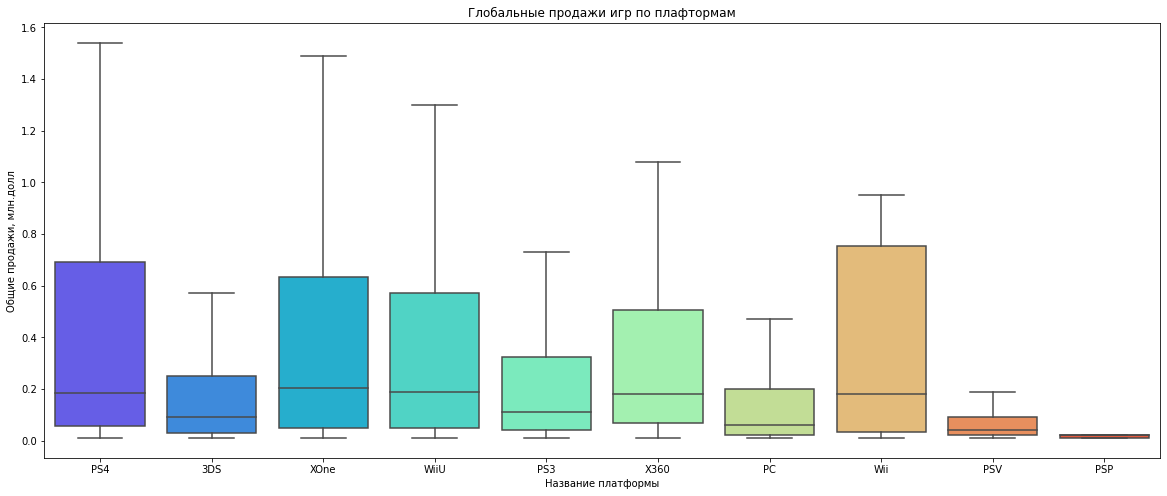

In [31]:
fig = plt.subplots(figsize=(20,8))
plt.title("Глобальные продажи игр по плафтормам")
plot = sns.boxplot(x="platform", y="total_sales", data=df_2014_2016, palette='rainbow', showfliers=False)
plt.xlabel('Название платформы')
plt.ylabel('Общие продажи, млн.долл')
plt.show()

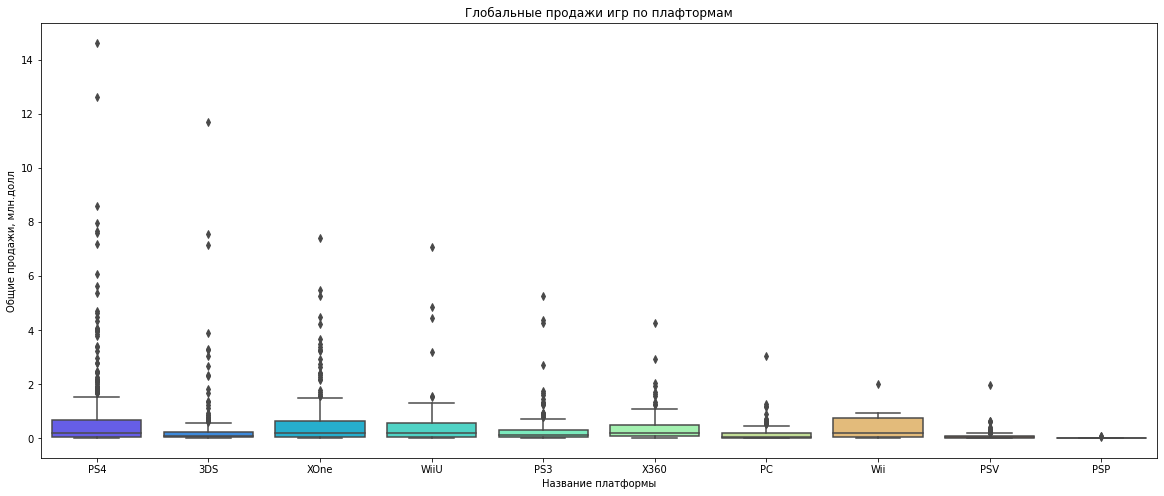

In [32]:
fig = plt.subplots(figsize=(20,8))
plt.title("Глобальные продажи игр по плафтормам")
sns.boxplot(x="platform", y="total_sales", data=df_2014_2016, palette='rainbow')
plt.xlabel('Название платформы')
plt.ylabel('Общие продажи, млн.долл')
plt.show()

Мы можем заметить, что медианные значения продаж смещены к нижнему краю – то есть на всех платформах выходит много игр с относительно небольшими продажами. При этом везде есть небольшое количество бестселлеров, продажи которых могут многократно превышать обычные значения. Из-за чего, на одних из самых популярных плафтормах XBoxOne, PS4, PS3, XBox360, Wii, WiiU появляются длинные "усы" сигнализирующее о наличии выдающихся значений.

Это может быть связано с разнобразием игр на ведущих платформах: поскольку платформы Playstation и Xbox достаточно давно приобрели популярность среди потребителей, они могут позволить себе выпуск достаточно ранжированного по цене игрового контента.

## Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков?

Возмем за самую популярную платформу PS4, так как за период 2014-2016 она является самой популярной. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

Корреляция количества продаж платформе PS4 от оценки пользователей:  -0.031957110204556376


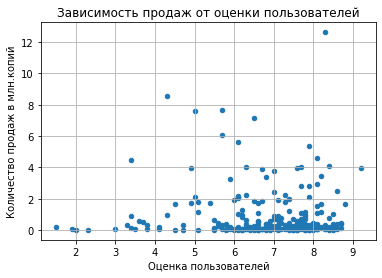

In [33]:
df_2014_2016.query('platform == "PS4"')\
.plot(kind='scatter',
      x='user_score',
      y='total_sales',
      grid=True,
      xlabel = 'Оценка пользователей',
      ylabel = 'Количество продаж в млн.копий',
      title = 'Зависимость продаж от оценки пользователей')

print('Корреляция количества продаж платформе PS4 от оценки пользователей: ', df.query('platform == "PS4"')['total_sales']\
.corr(df.query('platform == "PS4"')['user_score']))

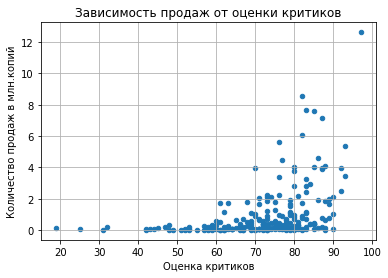

Корреляция количества продаж на платформе PS4 от оценки критиков:  0.406567902061781


In [34]:
df_2014_2016.query('platform == "PS4"')\
.plot(kind='scatter',
      x='critic_score',
      y='total_sales', 
      xlabel = 'Оценка критиков',
      grid=True,
      ylabel = 'Количество продаж в млн.копий',
      title = 'Зависимость продаж от оценки критиков')
plt.show()

print('Корреляция количества продаж на платформе PS4 от оценки критиков: ',df.query('platform == "PS4"')['total_sales']\
.corr(df.query('platform == "PS4"')['critic_score']))

Коэффициент корреляции между оценкой покупателей и совокупными продажами составил -0.03, что говорит об отсутствии зависимости между этими показателями. При этом диаграмма рассения схожа с диаграммой рассеяния по оценкам критиков, но имеет больший разброс при низких оценках. Возможно, это связано с тем, что потребитель сначала покупает игру, а затем, поиграв, ставит ей оценку, исходя из субъективного впечатления.

Коэффициент корреляции между оценкой критиков и совокупными продажами составил 0.4, что говорит о небольшой зависимости между этими показателями. Этот же вывод мы можем сделать из диаграммы рассеяния: игры с низкими оценками критиков практически не продаются, в то время как игры с высокими оценками имеют больше продаж. Скорее всего, критиками оцениваются не все игры, а наиболее популярные у покупателей.

Тем не менее, связь оценок с сумммами продаж не является сильной. Соответственно, на продажи игр влияют какие-то иные факторы. Для того чтобы убедится в этом построим такие же диаграммы для остальных 

In [35]:
def other_platform_matrix(name_of_platform):
    platform = df_2014_2016[df_2014_2016['platform'] == name_of_platform]
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.scatterplot(x='user_score', y='total_sales', data=platform, ax=ax[0])
    sns.scatterplot(x='critic_score', y='total_sales', data=platform, ax=ax[1])
    fig.suptitle(name_of_platform, fontsize=15)
    ax[0].set(xlabel='Оценка пользователей')
    ax[1].set(xlabel='Оценка критиков')
    ax[0].set(ylabel='Количество продаж')
    ax[1].set(ylabel='Количество продаж')
    plt.show()
    
    correl = platform['user_score'].corr(platform['total_sales'])
    critic_correl = platform['critic_score'].corr(platform['total_sales'])
    print(f'Корреляция количества продаж на платформе {name_of_platform} от оценки пользователей: {correl}')
    print(f'Корреляция количества продаж на платформе {name_of_platform} от оценки критиков: {critic_correl}')

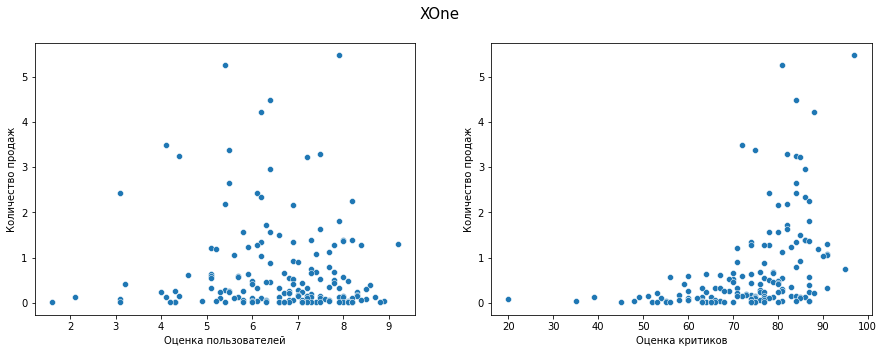

Корреляция количества продаж на платформе XOne от оценки пользователей: -0.0703839280647581
Корреляция количества продаж на платформе XOne от оценки критиков: 0.42867694370333226


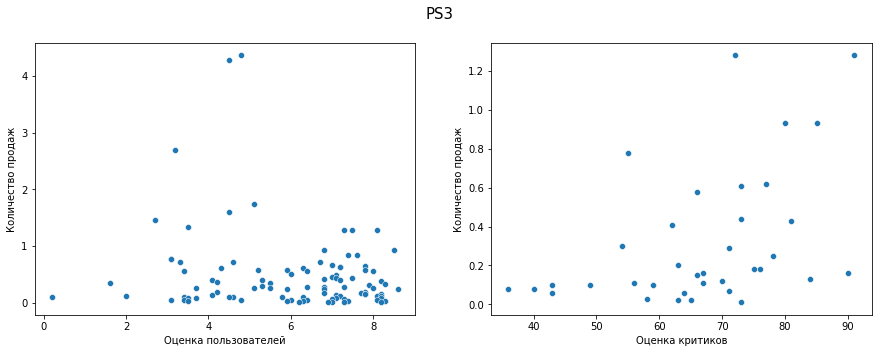

Корреляция количества продаж на платформе PS3 от оценки пользователей: -0.16676141347662118
Корреляция количества продаж на платформе PS3 от оценки критиков: 0.44657460493190704


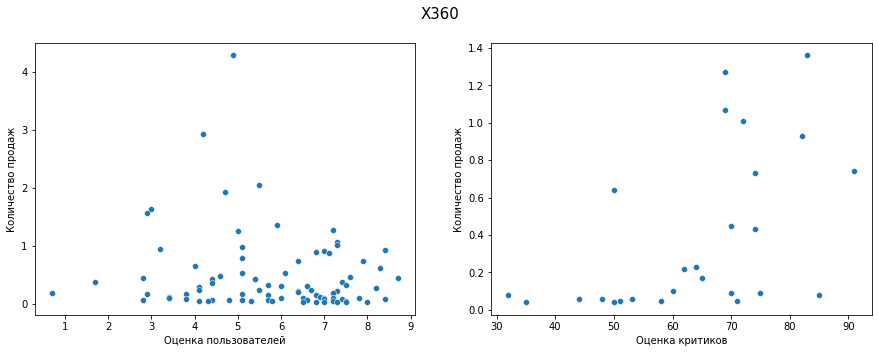

Корреляция количества продаж на платформе X360 от оценки пользователей: -0.138444570945665
Корреляция количества продаж на платформе X360 от оценки критиков: 0.5257228356581523


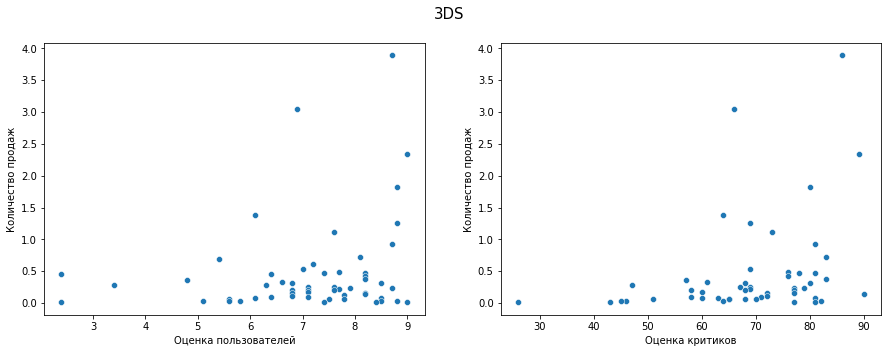

Корреляция количества продаж на платформе 3DS от оценки пользователей: 0.2151932718527028
Корреляция количества продаж на платформе 3DS от оценки критиков: 0.314117492869051


In [36]:
other_platforms = ['XOne', 'PS3', 'X360', '3DS']
for platform in other_platforms:
    other_platform_matrix(platform)

Коэффициент корреляции между оценкой критиков и совокупными продажами для других платформ из топ 5 варьируется от -0.17 до 0.22, что говорит о незначительной зависимости между этими показателями. Диаграмма рассеяния тоже имеет больше разбросанных значений при средних и низких оценках. 

Коэффициент корреляции между оценкой покупателей и совокупными продажами варьируется примерно от 0.31 до 0.52. Это значение примерно равно коэффициенту корреляции на платформе PS4, однако всё равно нельзя сказать, что продажи напрямую зависят от оценок пользователей. Соответственно, проанализровав топ 5 плафторм, можно сказать, что общие продажи не зависят от того, какую оценку игре поставили пользователи или критики. Такие данные лучше не учитывать при выборе стратегии компании.

## Изучение распределения по жанрам

In [37]:
df_2014_2016['genre'].value_counts()

Action          619
Role-Playing    221
Adventure       185
Sports          161
Shooter         128
Misc            113
Racing           69
Fighting         60
Simulation       44
Platform         38
Strategy         37
Puzzle           14
Name: genre, dtype: int64

In [38]:
df_2014_2016.pivot_table(
    columns = 'platform',
    index = 'genre',
    values = 'total_sales',
    aggfunc='sum').fillna(0)

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
genre,,,,,,,,,,
Action,22.06,5.34,18.10,91.62,0.20,7.47,1.19,9.99,12.33,31.06
Adventure,1.57,0.39,1.98,6.34,0.05,2.29,0.18,0.17,1.90,2.68
Fighting,8.10,0.10,2.89,7.73,0.00,0.69,0.00,5.88,0.66,2.17
Misc,3.85,0.05,6.69,7.77,0.02,3.43,3.14,4.59,1.27,6.74
Platform,3.98,0.06,0.76,5.42,0.00,0.19,0.00,6.87,0.19,0.62
Puzzle,0.87,0.00,0.04,0.02,0.00,0.06,0.00,1.22,0.00,0.00
Racing,0.00,0.64,1.00,10.16,0.00,0.10,0.00,7.09,1.64,6.89
Role-Playing,40.02,4.87,6.63,28.99,0.00,6.10,0.00,1.52,2.76,10.55
Shooter,0.00,5.79,12.17,78.46,0.00,0.64,0.00,4.83,13.66,55.39


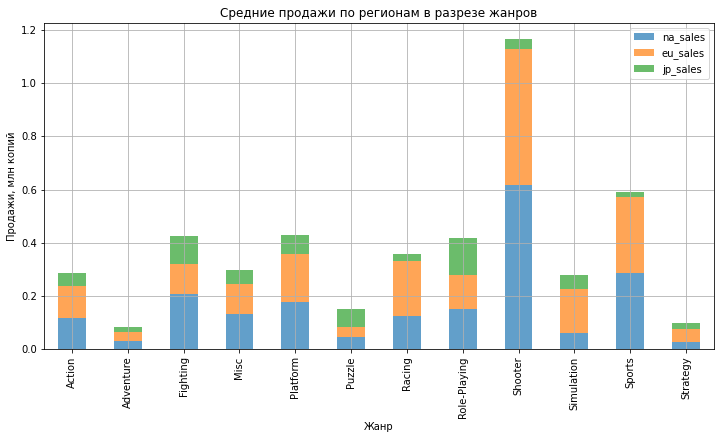

In [39]:
fig, ax = plt.subplots()
df_2014_2016.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']].agg('mean').plot(kind='bar',stacked=True, ax=ax, figsize=(12,6), alpha=0.7)
ax.set_title('Средние продажи по регионам в разрезе жанров')
ax.set_ylabel('Продажи, млн копий')
ax.set_xlabel('Жанр')
ax.grid(True)
plt.show()

Самым прибыльным жанром является шутеры, который наиболее популярен в Америке и Европе. В топ-5 также входят игры жанра спорт, файтинги, платформеры и ролевые игры.  
Самыми неперспективными жанрами игр для продаж является приключения, стратегии и головоломки.

**Вывод:**

На основе анализа продаж можем сделать прогноз, что потенциально прибыльными в 2017 году будут платформы: XOne, которая уже несколько лет пользуется популярностью у потребителей игр; Playstation 4, только набирающая обороты и приносящая самый высокий доход от продаж.

При анализе связи между оценкой игры и совокупными продажами было выявлено, что между оценкой критиков и продажами есть слабая связь, причём для популярных платформ она чуть сильнее, чем для непопулярных; и между оценкой пользователей и совокупными продажами нет связи (ни для популярных, ни для непопулярных платформ). С одной стороны, это может быть связано с тем, что люди обращают внимание на оценку игры, прежде чем покупают её (но корреляция невысокая, соответственно, это точно не ключевой показатель).

## Составление портрета пользователя каждого региона

In [41]:
# Функция для построения графиков по заданному параметру в каждом регионе.
def region_stat(ind, xlabel_name):
    na_temp = df_2014_2016.pivot_table(index=ind, values='na_sales', aggfunc='sum')\
    .sort_values(by='na_sales', ascending=False).head()\
    .reset_index()
    eu_temp = df_2014_2016.pivot_table(index=ind, values='eu_sales', aggfunc='sum')\
    .sort_values(by='eu_sales', ascending=False).head()\
    .reset_index()
    jp_temp = df_2014_2016.pivot_table(index=ind, values='jp_sales', aggfunc='sum')\
    .sort_values(by='jp_sales', ascending=False).head()\
    .reset_index()
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    sns.barplot(data=na_temp, x=ind, y='na_sales', palette='muted', ax=ax1)
    sns.barplot(data=eu_temp, x=ind, y='eu_sales', palette='muted', ax=ax2)
    sns.barplot(data=jp_temp, x=ind, y='jp_sales', palette='muted', ax=ax3)
    ax1.set(xlabel=xlabel_name)
    ax2.set(xlabel=xlabel_name)
    ax3.set(xlabel=xlabel_name)
    ax1.set(ylabel='Количество продаж')
    ax2.set(ylabel='Количество продаж')
    ax3.set(ylabel='Количество продаж')
    ax1.set(title='Сервеная Америка')
    ax2.set(title='Европа')
    ax3.set(title='Япония')
    plt.show()

### Платформа

In [42]:
df_2014_2016.pivot_table(
    index = 'platform',
    values = ['na_sales', 'eu_sales', 'jp_sales'],
    aggfunc =  'sum')\
.apply(lambda col: col / col.sum(), axis=0)\
.style.format("{:.1%}")

,eu_sales,jp_sales,na_sales
platform,,,
3DS,6.0%,47.5%,8.0%
PC,6.6%,0.0%,2.5%
PS3,9.4%,12.1%,7.8%
PS4,48.0%,16.1%,34.7%
PSP,0.0%,0.4%,0.0%
PSV,1.3%,15.6%,0.9%
Wii,1.0%,0.0%,0.7%
WiiU,4.9%,7.9%,6.8%
X360,5.7%,0.1%,10.0%


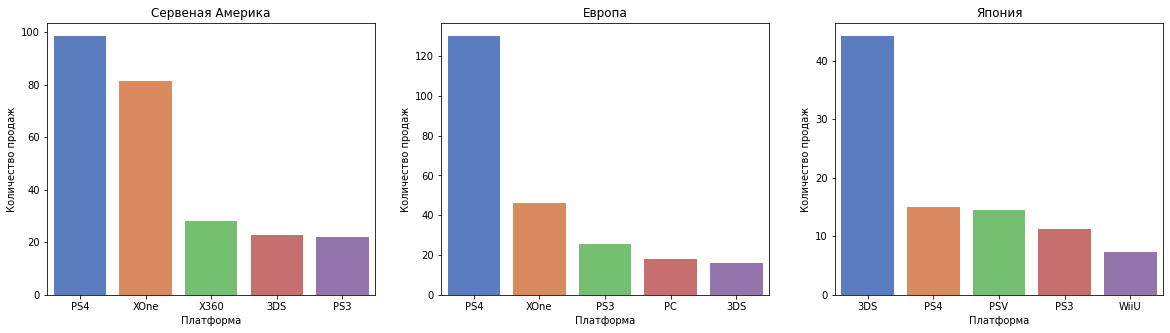

In [43]:
region_stat('platform', 'Платформа')

Разница в популярностях платформ очевидна. Пользователь из Севрной Америки предпочитает либо PS4, либо Xbox One. Доля остальных платформ в этом регионе значительно меньше. В Европейском регионе доминирует PS4, а вот в Японии самая популярная платформа - 3DS, затем идут обе консоли от PlayStation.  Япония - страна производства Sony и Nintendo, поэтому доля остальных платформ там незначительна.

### Жанр

In [47]:
df_2014_2016.pivot_table(
    index = 'genre',
    values = ['na_sales', 'eu_sales', 'jp_sales'],
    aggfunc =  'sum')\
.apply(lambda col: col / col.sum(), axis=0)\
.style.format("{:.1%}")

,eu_sales,jp_sales,na_sales
genre,,,
Action,27.6%,31.8%,25.5%
Adventure,2.4%,3.9%,2.0%
Fighting,2.5%,6.8%,4.4%
Misc,4.8%,6.0%,5.3%
Platform,2.5%,2.9%,2.4%
Puzzle,0.2%,1.0%,0.2%
Racing,5.2%,1.9%,3.1%
Role-Playing,10.4%,33.5%,11.8%
Shooter,24.2%,5.2%,27.8%


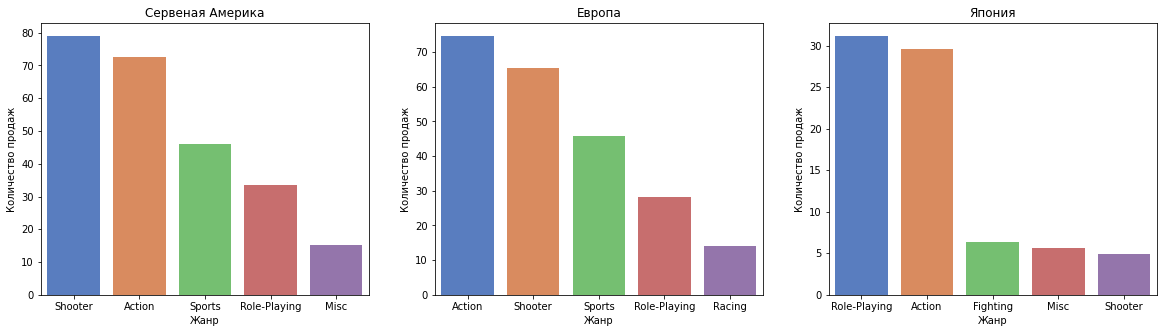

In [48]:
region_stat('genre', 'Жанр')

В Северной Америке самая большая доля рынка от глобальных продаж, количество продаж постепенно снижается: шутеры, экшен, спорт, ролевые и разное. График для Европы похож на распределение жанров для Америки, однако топ-1 теперь занимает экшен, а затем уже идут шутеры. В Японии снова особенная картина - 2 наиболее популярных жанра теперь ролевые игры и экшен, а вот доля остальных намного меньше. Также впервые появляется файтинг.

### Рейтинг

In [49]:
df_2014_2016.pivot_table(
    index = 'rating',
    values = ['na_sales', 'eu_sales', 'jp_sales'],
    aggfunc =  'sum')\
.apply(lambda col: col / col.sum(), axis=0)\
.style.format("{:.1%}")

,eu_sales,jp_sales,na_sales
rating,,,
E,21.4%,9.6%,17.9%
E10+,9.7%,4.8%,11.7%
M,34.5%,8.6%,33.9%
T,12.6%,15.9%,13.7%
no_ESRB,21.8%,61.1%,22.8%


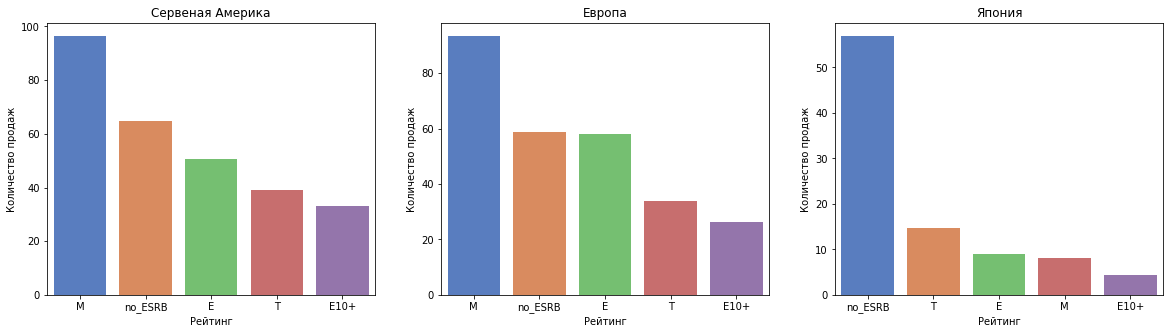

In [50]:
region_stat('rating', 'Рейтинг')

Игры без рейтинга занимают первое место в Японии, и значительную долю в каждом регионе. Так как этим значением мы ранее заполнили пропуски, возможно, не все игры подвергались оценке ESRB. Кроме того, в Японии она вовсе почти не используется. В Америке и Европе наиболее популярны игры с рейтином **М** (для лиц старше 17 лет), однако в Японии их обгоняют игры с рейтингом **Т** (для лиц старше 13 лет). Кроме того, во всех трех регионах наименьшие продажи у игр с рейтингом **Е10+** (для лиц старше 10 лет).


**Вывод:**

Если рассматривать наиболее перспективные платформы на 2017 год, то можно наблюдать следующее распределение популярности по представленным регионам:

В Северной Америке и Европе наиболее популярна Playstation 4 .
В Японии самой популярной является 3DS, которая в других регионах занимет второе место из перспективных.
В Северной Америке и Европе также популярна платформа XBoxOne, игры на которую практически не продаются в Японии.
В случае с жанрами распределение тоже преобретаер корреляционный характер, так, например:

Во всех трёх регионах достаточно популярны игры в жанре "Экшен".
В Японии самыми популярными являются игры в жанре "Ролевые".
Различия в приверженности определённым жанрам могут быть в том числе связаны с различиями в популярности платформ в регионах. К примеру, игры в жанре "Шутер" совсем не популярны в Японии.

В то же время, следует учитывать и культурные особенности, формирующие предпочтения потребителей. В Северной Америке и Европе очень схожи доли продаж популярных жанров, но и культура достаточно близка; в Японии предпочтения отличаются.

Таким образом, в Северной Америке и Европе схожая структура продаж по рейтингу игр. В Японии предпочтения довольно сильно отличаются: подростковые игры более популярны, чем игры для взрослых. В остальном структура похожа. На игры для детей младшего возраста спроса почти нет ни в одном регионе.

## Проверка гипотез

Теперь проверим гипотезы о средних значениях пользовательского рейтинга.

### Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

In [51]:
# Сохраним в отдельных переменных данные об нужных платформах.
xone_rate = df_2014_2016.query('platform == "XOne"')['user_score']
pc_rate = df_2014_2016.query('platform == "PC"')['user_score']

In [52]:
xone_rate.mean()

6.594545454545454

In [53]:
pc_rate.mean()

6.298360655737704

In [54]:
def hist(data, title_1, title_2):    # напишем фунцию для построения графиков  
    sns.histplot(data)
    plt.title(title_2, loc='left')
    plt.show()

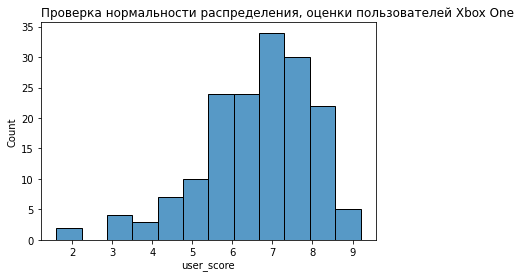

In [55]:
hist(
    xone_rate, 
    'Распределение оценок пользователей Xbox One',
    'Проверка нормальности распределения, оценки пользователей Xbox One'
)

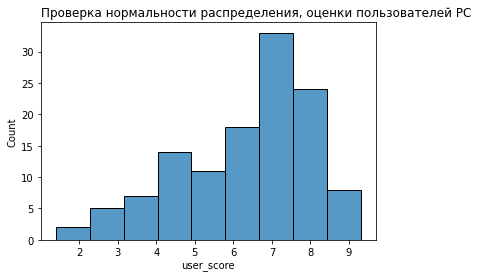

In [56]:
hist(
    pc_rate, 
    'Распределение оценок пользователей PC',
    'Проверка нормальности распределения, оценки пользователей PC'
)

Данные распределены нормально, однако можно заметить некоторое смещение вправо.

**Нулевая гипотеза H0** - Средние двух генеральных совокупностей равны между собой.

**Альтернативная гипотеза H1** - Средние двух генеральных совокупностей не равны между собой.

Согласно центральной предельной теореме, выборочные средние распределены нормально вокруг истинного среднего генеральной совокупности, поэтому введём уровень значимости, определяющий близость к среднему значению: 5%.

Кроме того, дисперсия каждой выборки должна быть оценена по датасету каждой из выборок, а не по их объединению. Также отметим, что выборки являются независимыми.

Проверим гипотезы через распределение t-Стьюдента.

In [57]:
alpha = .05
results = st.ttest_ind(xone_rate, pc_rate,equal_var=False, nan_policy='omit')

print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.11601398086668943
Не получилось отвергнуть нулевую гипотезу


Получили результат: p-значение оказалось больше уровня значимости в 5%. Поэтому у нас не получается отвергнуть нулевую гипотезу: средние двух генеральных совокупностей равны между собой.

### Гипотеза 2. Средние пользовательские рейтинги жанров Action  и Sports  разные.

In [58]:
action_rate = df_2014_2016.query('genre == "Action"')['user_score']
sports_rate = df_2014_2016.query('genre == "Sports"')['user_score']

In [59]:
action_rate.mean()

6.760606060606061

In [60]:
sports_rate.mean()

5.225196850393701

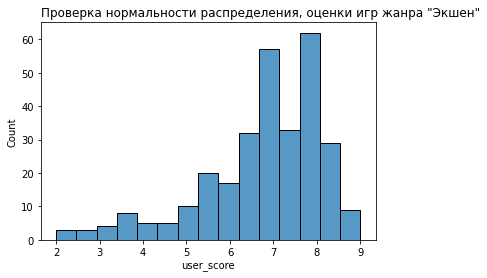

In [61]:
hist(
    action_rate, 
    'Распределение оценок жанра "Экшен"',
    'Проверка нормальности распределения, оценки игр жанра "Экшен"'
)

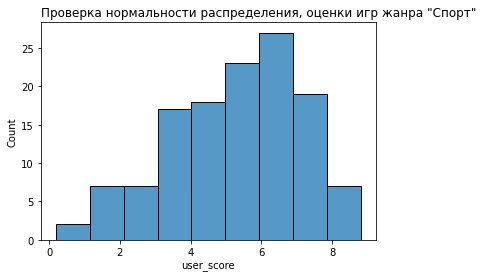

In [62]:
hist(
    sports_rate, 
    'Распределение оценок жанра "Спорт"',
    'Проверка нормальности распределения, оценки игр жанра "Спорт"'
)

**Нулевая гипотеза H0** - Средние двух генеральных совокупностей равны между собой.

**Альтернативная гипотеза H1** - Средние двух генеральных совокупностей не равны между собой.

In [63]:
alpha = .05
results = st.ttest_ind(action_rate, sports_rate,equal_var=False, nan_policy='omit')

print(results.pvalue) 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.182555038264477e-14
Отвергаем нулевую гипотезу


Получили результат: p-значение оказалось меньше уровня значимости в 5%. Соответственно, мы отвергли нулевую гипотезу; приняли альтернативную гипотезу: средние двух генеральных совокупностей не равны между собой.

**Вывод:** Средние пользовательские рейтинги жанров Action и Sports различаются.

# Общий вывод

Итак, на основе исторических данных о продажах игр за 2016 нам необходимо было выявить закономерности, определяющие успешность игр.

В процессе предобработки данных:

<ul>
  <li>Строки с пропусками были удалены или заполнены в соответствии с определённым алгоритмом</li>
  <li>Явные дубликаты были обработаны и устранены</li>
  <li>Был изменён тип данных в 3-х столбцах</li>
  <li>Несколько строк с пропусками были удалены из-за незначительного показателя количества этих же пропусков</li>
</ul>




В ходе исследования мы сделали следующие выводы:

<ul>
  <li>Cамыми потенциально прибыльными платформами являются Sony PlayStation 4 и Xbox One. Какое-то время будут актуальны игры для платформ Nintendo 3DS</li>
  <li>В Америке и Европе наиболее популярны игры на PS4 и Xbox One, а в Японии - на 3DS, PS4 и PS3</li>
  <li>Наиболее популярны жанры Action, Shooter и Sports (для японского рынка наиболее актуальны игры в жанре Role-Playing);</li>
  <li>В целом, оценки как пользователей, так и критиков не сильно влияют на продажи. Однако из этих двух показателей оценки критиков стоит принять во внимание. </li>
</ul>







**Рекомендации:**

<ul>
  <li>Не ориентироваться при продаже игр на пользовательские оценки; не придавать большого значения оценкам критиков, но принимать их во внимание.</li>
  <li>Учесть, что срок устаревания платформы составляет 2-3 года; не выставлять на продажу игры на платформах, для которых этот срок приближается к 4-5 годам.</li>
  <li>В жанровом разрезе по регионам магазину Стримчик следует осуществлять реализацию в следущем ключе: в Северной Америке и Европе следует продавать игры на Playstation4 и XboxOne, делая акцент на играх в жанре "Экшен" и "Шутер"; в Японии следует продавать игры на 3DS, делая акцент на играх в жанрах "Ролевые" и "Экшен"</li>
  <li>В каждом из регионов рекомендуется осуществлять продажи игр с рейтингом E. В Северной Америке и Европе также возможны осуществление прибыльных продаж игр с рейтингом M ("для взрослых"), а в Японии - с рейтингом T ("для подростков").</li>
</ul>



